In [15]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
import amir_tools as at
torch.cuda.set_device(0)

In [16]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/snomed_codes.csv",sep=",")[["Dx","SNOMEDCTCode"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMEDCTCode"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_ID = "CPSC2018"
# DATASET_ID = "ChapmanShaoxing"
DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


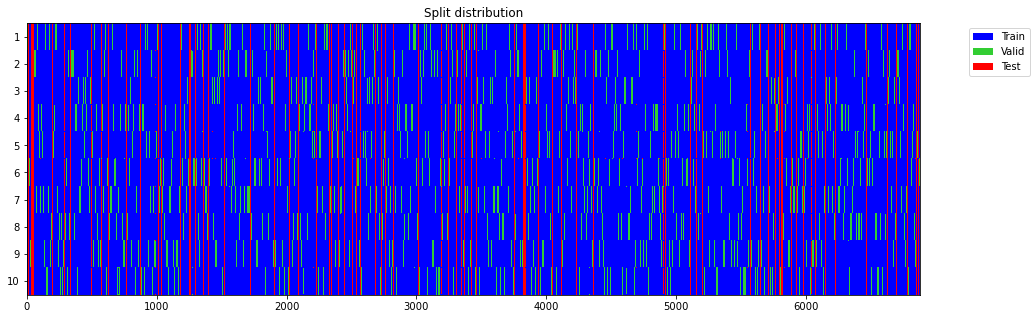

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [17]:

cv_splits = get_splits(y.to_numpy(), n_splits = 10, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

# INCEPTION CSPC RAW ANALYSIS

In [12]:
max_len = 10000
sf = 0.5
model_type = "inception"
data_set = "CPSC"
processes = []

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s"%(model_type,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))


[]


# cspc + inception + all funcs analysis

In [ ]:
max_len = 10000
sf = 0.5
model_type = "inception"
data_set = "CPSC"
processes = ["sc","n","bp","sh"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s"%(model_type,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))


In [29]:
next(iter(dls.valid))

(TSTensor(samples:128, vars:12, len:5000, device=cuda:0),
 TensorMultiCategory([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0'))

In [ ]:
max_len = 10000
sf = 0.5
model_type = "inception"
data_set = "CPSC"
processes = ["sc","n","bp","sh"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s"%(model_type,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s_f1.csv"%(model_type,processing_type,max_len,DATASET_ID))


In [ ]:
#df for auc
aucs_list = []
for targets,probs in zip(targets_list,probas_list):
    fig, aucs = at.draw_aucs(targets,probs,list(dls.vocab.o2i.keys()))
    aucs_list.append(dict(aucs))
auc_df = pd.DataFrame(aucs_list)

## scale + normal + bandpass

In [43]:
max_len = 10000
sf = 0.5
model_type = "inception"
data_set = "CPSC"
processes = ["sc","n","bp"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s"%(model_type,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))


['sc', 'n', 'bp']


In [46]:
f1_df.median()

1st degree av block             0.860317
atrial fibrillation             0.945148
left bundle branch block        0.911840
premature atrial contraction    0.759480
right bundle branch block       0.946151
sinus rhythm                    0.806625
st depression                   0.810050
st elevation                    0.525063
ventricular ectopics            0.845929
micro avg                       0.863821
macro avg                       0.824211
weighted avg                    0.861098
samples avg                     0.838185
dtype: float64

## scale + normal 

In [47]:
max_len = 10000
sf = 0.5
model_type = "inception"
data_set = "CPSC"
processes = ["sc","n"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s"%(model_type,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))


['sc', 'n']


## scale

In [51]:
max_len = 10000
sf = 0.5
model_type = "inception"
data_set = "CPSC"
processes = ["sc"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s"%(model_type,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))


['sc']


### Table Generation:


In [30]:
path = "csvs/" # use your path
all_files = glob.glob(path + "/inception*CPSC2018.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, header=0)
    df["experiment"] = filename.split("/")[-1].split(".")[0]
    li.append(df)

    
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.drop(columns=frame.columns[0])
frame.head()

,1st degree av block,atrial fibrillation,left bundle branch block,premature atrial contraction,right bundle branch block,sinus rhythm,st depression,st elevation,ventricular ectopics,micro avg,macro avg,weighted avg,samples avg,experiment
0,0.854962,0.937759,0.918919,0.728972,0.923483,0.793651,0.826816,0.526316,0.855422,0.858896,0.818478,0.856420,0.834546,inception_sc-n-bp_10000_CPSC2018
1,0.833333,0.945148,0.923077,0.774775,0.940874,0.811765,0.811111,0.600000,0.833333,0.866303,0.830380,0.863926,0.838428,inception_sc-n-bp_10000_CPSC2018
2,0.865672,0.945148,0.850000,0.782609,0.945736,0.789189,0.802198,0.512821,0.810127,0.859851,0.811500,0.857781,0.836002,inception_sc-n-bp_10000_CPSC2018
3,0.867647,0.965812,0.950000,0.750000,0.953608,0.802139,0.808989,0.523810,0.857143,0.872727,0.831016,0.871410,0.855410,inception_sc-n-bp_10000_CPSC2018
4,0.888889,0.953586,0.904762,0.752294,0.948454,0.817204,0.820225,0.486486,0.848485,0.873392,0.824487,0.870000,0.847404,inception_sc-n-bp_10000_CPSC2018


In [31]:
frame.groupby("experiment").median()

,1st degree av block,atrial fibrillation,left bundle branch block,premature atrial contraction,right bundle branch block,sinus rhythm,st depression,st elevation,ventricular ectopics,micro avg,macro avg,weighted avg,samples avg
experiment,,,,,,,,,,,,,
inception_raw_10000_CPSC2018,0.860390,0.942889,0.902381,0.728972,0.946429,0.790356,0.827772,0.512821,0.810969,0.861125,0.815148,0.858535,0.834304
inception_sc-n-bp-sh_10000_CPSC2018,0.867950,0.943174,0.871795,0.732357,0.944941,0.790428,0.782371,0.513158,0.824623,0.857628,0.812525,0.855021,0.834182
inception_sc-n-bp_10000_CPSC2018,0.860317,0.945148,0.911840,0.759480,0.946151,0.806625,0.810050,0.525063,0.845929,0.863821,0.824211,0.861098,0.838185
inception_sc-n_10000_CPSC2018,0.861448,0.942913,0.908907,0.751311,0.947505,0.810050,0.810837,0.500000,0.830926,0.861403,0.815315,0.858093,0.839034
inception_sc_10000_CPSC2018,0.858305,0.941423,0.904762,0.759011,0.946015,0.803255,0.825177,0.459064,0.854540,0.865649,0.816061,0.862641,0.844614


# CSPC + minirocket 

## raw

In [ ]:
max_len = 6000
sf = 0.5
model_type = "minirocket"
data_set = "CPSC2018"
processes = []

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    print(cv_num)
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1.median()

In [5]:
dls.vars, dls.c,dls.len

(12, 9, 6000)

In [6]:
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df.median()

1st degree av block             0.811555
atrial fibrillation             0.915462
left bundle branch block        0.850000
premature atrial contraction    0.372358
right bundle branch block       0.907246
sinus rhythm                    0.637298
st depression                   0.730248
st elevation                    0.305361
ventricular ectopics            0.618402
micro avg                       0.764165
macro avg                       0.687524
weighted avg                    0.753884
samples avg                     0.706817
dtype: float64

In [9]:
max_len = 6000
sf = 0.5
model_type = "minirocket"
data_set = "CPSC2018"
processes = ["sc"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df.median()

['sc']
0


1


2


3


4


5


6


7


8


9


1st degree av block             0.817344
atrial fibrillation             0.914162
left bundle branch block        0.886305
premature atrial contraction    0.431193
right bundle branch block       0.915982
sinus rhythm                    0.693182
st depression                   0.715839
st elevation                    0.332895
ventricular ectopics            0.607891
micro avg                       0.764447
macro avg                       0.697922
weighted avg                    0.758933
samples avg                     0.706914
dtype: float64

In [14]:
max_len = 6000
sf = 0.5
model_type = "minirocket"
data_set = "CPSC2018"
processes = ["sc","n"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df.median()

['sc', 'n']


1st degree av block             0.811152
atrial fibrillation             0.909481
left bundle branch block        0.839634
premature atrial contraction    0.405357
right bundle branch block       0.911876
sinus rhythm                    0.703146
st depression                   0.739957
st elevation                    0.329823
ventricular ectopics            0.638984
micro avg                       0.770334
macro avg                       0.701077
weighted avg                    0.764967
samples avg                     0.713464
dtype: float64

In [10]:
max_len = 6000
sf = 0.5
model_type = "minirocket"
data_set = "CPSC2018"
processes = ["sc","n","bp",]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df.median()

['sc', 'n', 'bp']


1st degree av block             0.802699
atrial fibrillation             0.909084
left bundle branch block        0.850000
premature atrial contraction    0.453288
right bundle branch block       0.902390
sinus rhythm                    0.693338
st depression                   0.731317
st elevation                    0.352564
ventricular ectopics            0.644841
micro avg                       0.770774
macro avg                       0.700076
weighted avg                    0.760271
samples avg                     0.719772
dtype: float64

In [11]:
max_len = 6000
sf = 0.5
model_type = "minirocket"
data_set = "CPSC2018"
processes = ["sc","n","bp","sh"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = MiniRocketPlus(dls.vars, dls.c,dls.len)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df.median()

['sc', 'n', 'bp', 'sh']


1st degree av block             0.830852
atrial fibrillation             0.915230
left bundle branch block        0.889229
premature atrial contraction    0.467428
right bundle branch block       0.906961
sinus rhythm                    0.697793
st depression                   0.746384
st elevation                    0.428105
ventricular ectopics            0.672792
micro avg                       0.784053
macro avg                       0.725375
weighted avg                    0.778323
samples avg                     0.733358
dtype: float64

# Chapman Dataset

In [49]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/snomed_codes.csv",sep=",")[["Dx","SNOMEDCTCode"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMEDCTCode"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
# DATASET_ID = "CPSC2018"
DATASET_ID = "ChapmanShaoxing"
DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


In [54]:
y.shape

(10247, 54)

In [43]:
y.columns[(y.sum()/len(y))>0.05]

Index(['left ventricular high voltage', 'atrial fibrillation',
       't wave abnormal', 'sinus bradycardia', 'supraventricular tachycardia',
       'sinus rhythm', 'sinus tachycardia', 'nonspecific st t abnormality'],
      dtype='object')

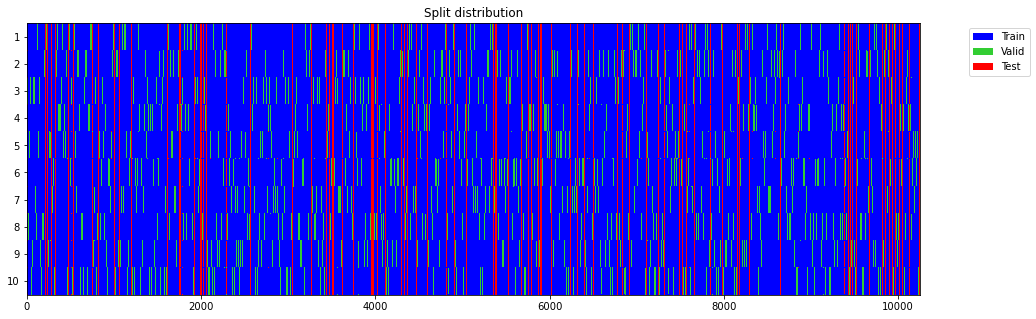

Counts by label: {'right bundle branch block': 454, 'atrial fibrillation': 1780, 't wave abnormal': 1876, 'sinus bradycardia': 3889, 'atrial flutter': 445, 'nonspecific st t abnormality': 1158, 'st depression': 402, 'sinus rhythm': 1826, 'left ventricular high voltage': 1295, 'sinus tachycardia': 1568, '1st degree av block': 247, 'atrial bigeminy': 3, 't wave inversion': 157, 'left bundle branch block': 205, 'p wave change': 95, 'qwave abnormal': 235, 'premature atrial contraction': 258, 'av block': 166, 'ventricular premature beats': 294, 'nonspecific intraventricular conduction disorder': 235, 'low qrs voltages': 249, 'left axis deviation': 382, 'right axis deviation': 215, 'countercolockwise rotation': 162, 'myocardial infarction': 40, 'st elevation': 176, 'ventricular trigeminy': 8, 'prolonged qt interval': 57, 'u wave abnormal': 22, 'early repolarization': 22, 'prolonged pr interval': 12, 'clockwise rotation': 76, 'left ventricular hypertrophy': 15, 'right atrial hypertrophy': 3, 

In [20]:

cv_splits = get_splits(y.to_numpy(), n_splits = 10, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

## Inception Raw

In [24]:
max_len = 5000
sf = 0.5
model_type = "inception"
data_set = "ChapmanShaoxing"
processes = []

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))


[]


## inception all chapman

In [30]:
max_len = 5000
sf = 0.5
model_type = "inception"
data_set = "ChapmanShaoxing"
processes = ["sc","n","bp","sh"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df

['sc', 'n', 'bp', 'sh']


,1st degree av block,2nd degree av block,atrial bigeminy,atrial fibrillation,atrial flutter,atrial tachycardia,atrioventricular node reentrant tachycardia,atrioventricular reentrant tachycardia,av block,clockwise rotation,...,ventricular escape beat,ventricular pre excitation,ventricular premature beats,ventricular trigeminy,wandering atrial pacemaker,wolff parkinson white pattern,micro avg,macro avg,weighted avg,samples avg
0,0.530612,0.0,0.0,0.922652,0.584615,0.315789,0.000000,0.0,0.272727,0.285714,...,0.0,0.0,0.800000,0.0,0.0,0.0,0.753401,0.260137,0.724123,0.811512
1,0.558824,0.0,0.0,0.928571,0.590164,0.133333,0.333333,0.0,0.095238,0.538462,...,0.0,0.0,0.686567,0.0,0.0,0.0,0.750540,0.251496,0.724000,0.802145
2,0.488889,0.0,0.0,0.923077,0.619718,0.400000,0.000000,0.0,0.380952,0.615385,...,0.0,0.0,0.745763,0.0,0.0,0.0,0.746750,0.249394,0.718837,0.807464
3,0.480000,0.0,0.0,0.907042,0.588235,0.285714,0.000000,0.0,0.190476,0.461538,...,0.0,0.0,0.721311,0.0,0.0,0.0,0.743373,0.248187,0.715263,0.801091
4,0.500000,0.0,0.0,0.924370,0.645161,0.476190,0.000000,0.0,0.111111,0.444444,...,0.0,0.0,0.819672,0.0,0.0,0.0,0.754098,0.258215,0.727218,0.812563
5,0.452830,0.0,0.0,0.926554,0.686567,0.210526,0.000000,0.0,0.148148,0.285714,...,0.0,0.0,0.838710,0.0,0.0,0.0,0.742616,0.239682,0.716346,0.797765
6,0.518519,0.0,0.0,0.898551,0.584615,0.300000,0.000000,0.0,0.181818,0.588235,...,0.0,0.0,0.653846,0.0,0.0,0.0,0.745847,0.242614,0.718814,0.801643
7,0.560000,0.0,0.0,0.908587,0.558824,0.235294,0.000000,0.0,0.153846,0.380952,...,0.0,0.0,0.763636,0.0,0.0,0.0,0.752170,0.242608,0.722492,0.808625
8,0.509804,0.0,0.0,0.930748,0.539683,0.333333,0.000000,0.0,0.190476,0.333333,...,0.0,0.0,0.819672,0.0,0.0,0.0,0.746471,0.242349,0.717518,0.804476
9,0.530612,0.0,0.0,0.930748,0.718750,0.315789,0.000000,0.0,0.210526,0.428571,...,0.0,0.0,0.819672,0.0,0.0,0.0,0.756956,0.248152,0.725061,0.813454


## inception sc+n+bp

In [31]:
max_len = 5000
sf = 0.5
model_type = "inception"
data_set = "ChapmanShaoxing"
processes = ["sc","n","bp",]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df

['sc', 'n', 'bp']


,1st degree av block,2nd degree av block,atrial bigeminy,atrial fibrillation,atrial flutter,atrial tachycardia,atrioventricular node reentrant tachycardia,atrioventricular reentrant tachycardia,av block,clockwise rotation,...,ventricular escape beat,ventricular pre excitation,ventricular premature beats,ventricular trigeminy,wandering atrial pacemaker,wolff parkinson white pattern,micro avg,macro avg,weighted avg,samples avg
0,0.458333,0.0,0.0,0.914601,0.705882,0.352941,0.0,0.0,0.095238,0.375000,...,0.0,0.0,0.763636,0.0,0.0,0.0,0.755404,0.258350,0.727831,0.810607
1,0.489796,0.0,0.0,0.928775,0.584615,0.480000,0.0,0.0,0.260870,0.666667,...,0.0,0.0,0.807018,0.0,0.0,0.0,0.746659,0.242212,0.714434,0.808597
2,0.541667,0.0,0.0,0.900552,0.600000,0.500000,0.0,0.0,0.105263,0.307692,...,0.0,0.0,0.736842,0.0,0.0,0.0,0.754749,0.273675,0.726720,0.811655
3,0.363636,0.0,0.0,0.932584,0.619718,0.210526,0.0,0.0,0.105263,0.400000,...,0.0,0.0,0.754098,0.0,0.0,0.0,0.749860,0.245403,0.724329,0.810957
4,0.530612,0.0,0.0,0.920904,0.628571,0.400000,0.0,0.0,0.095238,0.533333,...,0.0,0.0,0.769231,0.0,0.0,0.0,0.746176,0.259323,0.720280,0.807355
5,0.560000,0.0,0.0,0.910112,0.606061,0.444444,0.0,0.0,0.181818,0.333333,...,0.0,0.0,0.903226,0.0,0.0,0.0,0.752719,0.250863,0.721813,0.812869
6,0.458333,0.0,0.0,0.910615,0.676471,0.400000,0.0,0.0,0.173913,0.333333,...,0.0,0.0,0.813559,0.0,0.0,0.0,0.750640,0.246402,0.723292,0.812247
7,0.489796,0.0,0.0,0.920904,0.626866,0.421053,0.0,0.0,0.160000,0.400000,...,0.0,0.0,0.730159,0.0,0.0,0.0,0.754089,0.245102,0.722834,0.811726
8,0.489796,0.0,0.0,0.927778,0.613333,0.300000,0.0,0.0,0.200000,0.571429,...,0.0,0.0,0.785714,0.0,0.0,0.0,0.750640,0.246783,0.721314,0.806177
9,0.488889,0.0,0.0,0.922222,0.636364,0.300000,0.0,0.0,0.272727,0.571429,...,0.0,0.0,0.800000,0.0,0.0,0.0,0.752492,0.259583,0.722490,0.809934


## inception chapman ( sc + n)

In [32]:
max_len = 5000
sf = 0.5
model_type = "inception"
data_set = "ChapmanShaoxing"
processes = ["sc","n",]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df

['sc', 'n']


,1st degree av block,2nd degree av block,atrial bigeminy,atrial fibrillation,atrial flutter,atrial tachycardia,atrioventricular node reentrant tachycardia,atrioventricular reentrant tachycardia,av block,clockwise rotation,...,ventricular escape beat,ventricular pre excitation,ventricular premature beats,ventricular trigeminy,wandering atrial pacemaker,wolff parkinson white pattern,micro avg,macro avg,weighted avg,samples avg
0,0.509804,0.0,0.0,0.915254,0.615385,0.222222,0.0,0.0,0.200000,0.352941,...,0.0,0.0,0.779661,0.0,0.0,0.0,0.760114,0.262317,0.730934,0.816986
1,0.470588,0.0,0.0,0.903955,0.591549,0.380952,0.0,0.0,0.260870,0.500000,...,0.0,0.0,0.800000,0.0,0.0,0.0,0.753210,0.250883,0.721271,0.813269
2,0.468085,0.0,0.0,0.926027,0.625000,0.347826,0.0,0.0,0.166667,0.307692,...,0.0,0.0,0.736842,0.0,0.0,0.0,0.751060,0.248489,0.723843,0.805939
3,0.391304,0.0,0.0,0.922222,0.500000,0.400000,0.0,0.0,0.095238,0.461538,...,0.0,0.0,0.825397,0.0,0.0,0.0,0.746735,0.243829,0.715488,0.805626
4,0.440000,0.0,0.0,0.919668,0.580645,0.454545,0.0,0.0,0.181818,0.166667,...,0.0,0.0,0.766667,0.0,0.0,0.0,0.745470,0.249323,0.719822,0.803481
5,0.470588,0.0,0.0,0.927374,0.588235,0.285714,0.0,0.0,0.086957,0.714286,...,0.0,0.0,0.806452,0.0,0.0,0.0,0.752598,0.265386,0.728950,0.813009
6,0.461538,0.0,0.0,0.918310,0.634921,0.333333,0.0,0.0,0.166667,0.666667,...,0.0,0.0,0.758621,0.0,0.0,0.0,0.754192,0.255777,0.725074,0.811979
7,0.509804,0.0,0.0,0.914127,0.562500,0.400000,0.0,0.0,0.181818,0.266667,...,0.0,0.0,0.754717,0.0,0.0,0.0,0.745142,0.247188,0.717640,0.802967
8,0.520000,0.0,0.0,0.918033,0.523077,0.117647,0.0,0.0,0.166667,0.571429,...,0.0,0.0,0.703704,0.0,0.0,0.0,0.755682,0.248520,0.725681,0.813889
9,0.454545,0.0,0.0,0.916667,0.600000,0.333333,0.0,0.0,0.181818,0.533333,...,0.0,0.0,0.785714,0.0,0.0,0.0,0.753491,0.252374,0.723498,0.807467


# inception + chapman (sc)

In [33]:
max_len = 5000
sf = 0.5
model_type = "inception"
data_set = "ChapmanShaoxing"
processes = ["sc"]

batch_tfms = []

processing_type = '-'.join([x for x in processes])
if "sc" in processes:
    batch_tfms.append(tfs.Scale(scale_factor=sf,))
if "n" in processes:
    batch_tfms.append(tfs.Normalize())
if "bp" in processes:
    batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
if "sh" in processes:
    batch_tfms.append(tfs.RandomShift(0.1))
if len(processes)==0:
    processing_type = "raw"

print(processes)

tfms  = [None, TSMultiLabelClassification()]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12, ks = 130,nf=32 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))
    
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
# df for f1
f1_df = pd.DataFrame(reports)
f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
f1_df

['sc']


,1st degree av block,2nd degree av block,atrial bigeminy,atrial fibrillation,atrial flutter,atrial tachycardia,atrioventricular node reentrant tachycardia,atrioventricular reentrant tachycardia,av block,clockwise rotation,...,ventricular escape beat,ventricular pre excitation,ventricular premature beats,ventricular trigeminy,wandering atrial pacemaker,wolff parkinson white pattern,micro avg,macro avg,weighted avg,samples avg
0,0.500000,0.0,0.0,0.916905,0.621622,0.272727,0.0,0.0,0.000000,0.470588,...,0.0,0.0,0.700000,0.0,0.0,0.0,0.766180,0.272168,0.748697,0.821092
1,0.571429,0.0,0.0,0.919220,0.545455,0.444444,0.0,0.0,0.153846,0.470588,...,0.0,0.0,0.777778,0.0,0.0,0.0,0.769274,0.263666,0.746179,0.823033
2,0.425532,0.0,0.0,0.914601,0.637681,0.476190,0.0,0.0,0.083333,0.461538,...,0.0,0.0,0.705882,0.0,0.0,0.0,0.760340,0.259097,0.732467,0.817908
3,0.458333,0.0,0.0,0.913649,0.696970,0.300000,0.0,0.0,0.095238,0.500000,...,0.0,0.0,0.785714,0.0,0.0,0.0,0.772469,0.260103,0.742990,0.826089
4,0.448980,0.0,0.0,0.917127,0.646154,0.285714,0.0,0.0,0.080000,0.526316,...,0.0,0.0,0.800000,0.0,0.0,0.0,0.775120,0.271004,0.749787,0.831857
5,0.421053,0.0,0.0,0.904110,0.567164,0.272727,0.0,0.0,0.206897,0.333333,...,0.0,0.0,0.750000,0.5,0.0,0.0,0.772266,0.271291,0.746307,0.821679
6,0.400000,0.0,0.0,0.914286,0.527778,0.352941,0.0,0.0,0.105263,0.533333,...,0.0,0.0,0.800000,0.0,0.0,0.0,0.765217,0.264974,0.741213,0.818328
7,0.530612,0.0,0.0,0.933333,0.600000,0.315789,0.0,0.0,0.166667,0.307692,...,0.0,0.0,0.714286,0.0,0.0,0.0,0.759501,0.257192,0.734132,0.814915
8,0.444444,0.0,0.0,0.925208,0.686567,0.300000,0.0,0.0,0.166667,0.153846,...,0.0,0.0,0.758621,0.0,0.0,0.0,0.767356,0.255749,0.741429,0.824935
9,0.480000,0.0,0.0,0.923077,0.593750,0.347826,0.0,0.0,0.090909,0.533333,...,0.0,0.0,0.807018,0.0,0.0,0.0,0.764889,0.261891,0.738459,0.819287


## Loop for minirocket/chapman

In [ ]:
max_len = 5000
sf = 0.5
model_type = "minirocket"
data_set = "ChapmanShaoxing"
processes_combinations = [["sc","n","bp","sh"],["sc","n","bp"],["sc","n",],["sc",],[]]

for processes in processes_combinations:
    batch_tfms = []

    processing_type = '-'.join([x for x in processes])
    if "sc" in processes:
        batch_tfms.append(tfs.Scale(scale_factor=sf,))
    if "n" in processes:
        batch_tfms.append(tfs.Normalize())
    if "bp" in processes:
        batch_tfms.append(tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,))
    if "sh" in processes:
        batch_tfms.append(tfs.RandomShift(0.1))
    if len(processes)==0:
        processing_type = "raw"

    print(processes)

    tfms  = [None, TSMultiLabelClassification()]
    reports = []
    probas_list, targets_list = [],[]
    for cv_num in range(10):
        fold_splits = cv_splits[cv_num]
        dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
        dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
        metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

    #     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
        model = MiniRocketPlus(dls.vars, dls.c,dls.len)
        learn = Learner(dls, model, metrics=metrics, 
                        cbs=[ShowGraph()],
                        model_dir="models/10CV/")
        learn.load("%s_%s_%s_%s_%s"%(model_type,data_set,processing_type,max_len,cv_num))

        valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
        probas_list.append(valid_probas)
        targets_list.append(valid_targets)
        y_pred = (valid_preds>0)
        y_test = valid_targets

        report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
        reports.append(report)
    for report in reports:
        for k,v in report.items():
            report[k] = report[k]["f1-score"]
    # df for f1
    f1_df = pd.DataFrame(reports)
    f1_df.to_csv("csvs/%s_%s_%s_%s.csv"%(model_type,processing_type,max_len,DATASET_ID))
    print(model_type,processing_type,max_len,DATASET_ID)
#     print(processes)
    print(f1_df)

In [46]:
y.shape

(10247, 54)